In [0]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%load_ext autoreload

%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/sumie"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/sumie


In [0]:
import sumie.inputs
import sumie.sumie
import sumie.transforms
import sumie.objectives
import sumie.montage

In [14]:
model = torchvision.models.vgg16(pretrained=True).eval()
model.features[-1] = torch.nn.AdaptiveMaxPool2d((7, 7))
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

tensor(1.9138, device='cuda:0', grad_fn=<NegBackward>)
tensor(-102.5525, device='cuda:0', grad_fn=<NegBackward>)
tensor(-235.5791, device='cuda:0', grad_fn=<NegBackward>)
tensor(-378.0804, device='cuda:0', grad_fn=<NegBackward>)
tensor(-463.1269, device='cuda:0', grad_fn=<NegBackward>)
tensor(-594.6929, device='cuda:0', grad_fn=<NegBackward>)
tensor(-620.8400, device='cuda:0', grad_fn=<NegBackward>)
tensor(-665.2822, device='cuda:0', grad_fn=<NegBackward>)
tensor(-748.8251, device='cuda:0', grad_fn=<NegBackward>)
tensor(-822.2990, device='cuda:0', grad_fn=<NegBackward>)


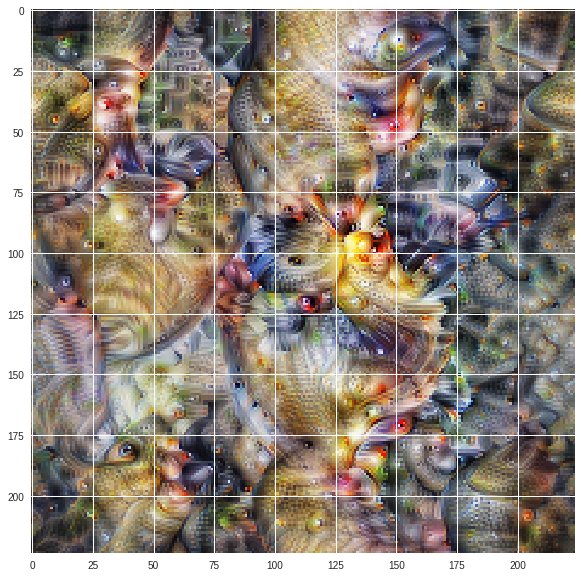

In [21]:
im = sumie.sumie.Image(224, transforms=
              [sumie.transforms.PositionJitter(8),
              sumie.transforms.Normalise()]
            )

device = 'cuda'
im.to(device)
model.to(device)
optimiser = torch.optim.Adam(im.parameters(), lr=0.05)
steps = 100
#channel = sumie.objectives.ConvChannel(model.features[28], 111)
animation = torch.zeros(100, 3, 224, 224)
channel = sumie.objectives.Linear(model.classifier[6], 0)
for i in range(steps):
    optimiser.zero_grad()
    out = model(im())
    
    loss = -channel.objective
    if i % (steps/10) == 0:
        print(loss)
    loss.backward()
    
    animation[i,:,:,:] = im.get_image().detach()
    optimiser.step()

fig = plt.figure(figsize=(10,10))
sumie.montage.show(255*im.get_image().cpu())

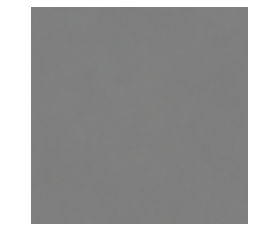

In [23]:
def to_frame(i):
  return animation[i,:,:,:].squeeze(0).permute((1, 2, 0)).numpy()

fig = plt.figure()
ax = plt.axes(xlim=(0, 224), ylim=(0, 224))
plt.axis('off')
ax.grid(False)
im=plt.imshow(to_frame(0))

# initialization function: plot the background of each frame
def init():
    im.set_data(to_frame(0))
    return [im]

# animation function.  This is called sequentially
def animate(i):
  if i<100:
    im.set_array(to_frame(i))
  else:
    im.set_array(to_frame(199-i))
  return [im]
  
anim = matplotlib.animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, 
                               blit=True, repeat=True)
#HTML(anim.to_jshtml())

In [24]:
HTML(anim.to_html5_video())